In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# derived from https://github.com/cvxgrp/lfd_lqr/blob/master/small%20random.ipynb
import numpy as np
from scipy.linalg import solve_discrete_are
import cvxpy as cp
from ADMM import *
import warnings
# warnings.filterwarnings('ignore')

In [3]:
np.random.seed(0)
n, m = 4, 2
A = np.random.randn(n, n)
A = A / np.abs(np.linalg.eig(A)[0]).max()
B = np.random.randn(n, m)
W = .25 * np.eye(n)
Q_true = np.eye(n)
R_true = np.eye(m)
P_true = solve_discrete_are(A, B, Q_true, R_true)
K_true = -np.linalg.solve(R_true + B.T @ P_true @ B, B.T @ P_true @ A)

In [4]:
def simulate(K, N=10, seed=None, add_noise=False):
    if seed is not None:
        np.random.seed(seed)
    x = np.random.multivariate_normal(np.zeros(n), W)
    xs = []
    us = []
    cost = 0.0
    for _ in range(N):
        u = K @ x
        if add_noise:
            u += 2*np.random.randn(m)
        xs.append(x)
        us.append(u)
        cost += (x @ Q_true @ x + u @ R_true @ u) / N
        x = A @ x + B @ u + np.random.multivariate_normal(np.zeros(n), W)
    xs = np.array(xs)
    us = np.array(us)
    
    return cost, xs, us

In [5]:
def simulate_variable_cost(A, B, Q_true, R_true, N=10, seed=None, add_noise=False):
    P_true = solve_discrete_are(A, B, Q_true, R_true)
    K = -np.linalg.solve(R_true + B.T @ P_true @ B, B.T @ P_true @ A)
    
    if seed is not None:
        np.random.seed(seed)
    x = np.random.multivariate_normal(np.zeros(n), W)
    xs = []
    us = []
    cost = 0.0
    for _ in range(N):
        u = K @ x
        if add_noise:
            u += 2*np.random.randn(m)
        xs.append(x)
        us.append(u)
        cost += (x @ Q_true @ x + u @ R_true @ u) / N
        x = A @ x + B @ u + np.random.multivariate_normal(np.zeros(n), W)
    xs = np.array(xs)
    us = np.array(us)
    
    return cost, xs, us

In [6]:
N_test = 10000
cost_true = simulate(K_true, N=N_test, seed=0)[0]
cost_noise = simulate(K_true, N=N_test, seed=0, add_noise=True)[0] 
cost_true, np.trace(P_true @ W), cost_noise

(1.7934243186095473, 1.8031177219720185, 64.75750340186758)

In [14]:
costs_lr = []
costs_admm = []
costs_admm_federated_personalized_same_traj = []

Ns = np.arange(6, 16)
for N in Ns:
    costs_lr += [[]]
    costs_admm += [[]]
    costs_admm_federated_personalized_same_traj += [[]]
    for k in range(1, 6):
        _, xs, us = simulate(K_true, N=N, seed=k, add_noise=True)
        
        

        def L(K):
            return cp.sum_squares(xs @ K.T - us)

        def r(K):
            return .01 * cp.sum_squares(K), []
        
        Klr = policy_fitting(L, r, xs, us)
        Kadmm = policy_fitting_with_a_kalman_constraint_local(L, r, xs, us, A, B, n_random=1)
        Kadmmpers = policy_fitting_with_a_kalman_constraint_federated_personalized(L, r, xs, us, A, B, n_random=1)
        
        cost_lr = simulate(Klr, N=N_test, seed=0)[0]
        cost_admm = simulate(Kadmm, N=N_test, seed=0)[0]
        cost_admmpers = simulate(Kadmmpers, N=N_test, seed=0)[0]
        
        if np.isnan(cost_lr) or cost_lr > 1e5 or cost_lr == np.inf:
            cost_lr = np.nan

        costs_lr[-1].append(cost_lr)
        costs_admm[-1].append(cost_admm)
        costs_admm_federated_personalized_same_traj[-1].append(cost_admmpers)

    print (" %03d | %3.3f | %3.3f | %3.3f | %3.3f | %3.3f" %
           (N, cost_true, cost_noise, np.nanmean(costs_lr[-1]), np.nanmean(costs_admm[-1]), np.nanmean(costs_admm_federated_personalized_same_traj[-1])))

/home/ahadrauf/anaconda3/envs/fedcontrol/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/home/ahadrauf/anaconda3/envs/fedcontrol/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/ahadrauf/anaconda3/envs/fedcontrol/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in add
  from ipykernel import kernelapp as app
/home/ahadrauf/anaconda3/envs/fedcontrol/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/ahadrauf/anaconda3/envs/fedcontrol/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/ahadrauf/anaconda3/envs/fedcontrol/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  


 006 | 1.793 | 64.758 | 8.913 | 5.063 | 2.633


/home/ahadrauf/anaconda3/envs/fedcontrol/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app


 007 | 1.793 | 64.758 | 14.594 | 4.948 | 5.082
 008 | 1.793 | 64.758 | 17.343 | 4.612 | 3.436
 009 | 1.793 | 64.758 | 37.219 | 3.014 | 2.939
 010 | 1.793 | 64.758 | 8.307 | 2.606 | 2.577
 011 | 1.793 | 64.758 | 9.916 | 2.725 | 2.720
 012 | 1.793 | 64.758 | 8.598 | 2.129 | 2.088
 013 | 1.793 | 64.758 | 8.454 | 2.344 | 2.312
 014 | 1.793 | 64.758 | 6.213 | 2.681 | 2.349
 015 | 1.793 | 64.758 | 6.211 | 2.958 | 2.577


In [18]:
costs_lr = np.array(costs_lr)
costs_admm = np.array(costs_admm)
costs_admm_pers = np.array(costs_admm_federated_personalized_same_traj)
mean_lr = np.nanmean(costs_lr, axis=1)
std_lr = np.nanstd(costs_lr, axis=1)
mean_admm = np.nanmean(costs_admm, axis=1)
std_admm = np.nanstd(costs_admm, axis=1)
mean_admm_pers = np.nanmean(costs_admm_pers, axis=1)
std_admm_pers = np.nanstd(costs_admm_pers, axis=1)

In [16]:
mean_lr

array([ 8.91268054, 14.59392337, 17.34318975, 37.21852609,  8.307456  ,
        9.91621225,  8.59844137,  8.45356521,  6.21348333,  6.21126823])

In [17]:
mean_admm

array([5.06339638, 4.94758551, 4.61217273, 3.01380934, 2.60610146,
       2.72475578, 2.12896984, 2.3436215 , 2.6808152 , 2.95810081])

In [19]:
mean_admm_pers

array([2.63335641, 5.08192893, 3.43582677, 2.93878438, 2.57666858,
       2.72024275, 2.08788334, 2.31177583, 2.3493319 , 2.57709424])

In [27]:
print(costs_lr)
print(costs_admm)
print(costs_admm_pers)
print(std_lr)
print(std_admm)
print(std_admm_pers)

[[  8.27857423          nan  10.26275903          nan   8.19670835]
 [  8.82412386          nan  28.55119423          nan   6.40645202]
 [  2.53279275          nan  23.32904462  38.66861862   4.84230302]
 [  2.51107349 145.92365633  21.15174196  10.44245469   6.063704  ]
 [  2.41085579  12.23982854  11.17821786  10.93440936   4.77396843]
 [  2.34804125  20.97373869  10.96346427  10.26739848   5.02841853]
 [  3.60376106  18.40854172   8.52104528   5.70385938   6.75499941]
 [  3.50220174  18.36467166   8.59224587   5.5816801    6.22702665]
 [  3.24239452   6.56537121   8.99408549   6.47915072   5.78641471]
 [  3.21971675   5.9697109   10.69416776   6.39291748   4.77982826]]
[[ 2.81445351  2.79688758  2.5985965  14.20694057  2.90010373]
 [ 3.00796425  4.97238222  4.68003257 10.07557839  2.00197011]
 [ 2.51129243  2.16443415  3.5439101  11.73472105  3.10650595]
 [ 2.34893798  2.42543953  3.50230784  4.34096971  2.45139163]
 [ 2.41822717  2.08092619  2.15472349  3.47267377  2.90395666]
 [ 2

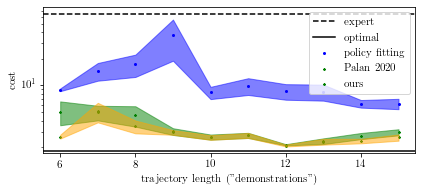

In [38]:
from utils import latexify
import matplotlib.pyplot as plt

plt.close()
latexify(fig_width=6, fig_height=2.8)
plt.axhline(cost_noise, ls='--', c='k', label='expert')

rng = np.arange(6, 16)
plt.scatter(rng, mean_lr, s=4, marker='o', c='blue', label='policy fitting')
plt.fill_between(rng, mean_lr - std_lr / 3, mean_lr + std_lr / 3, alpha=.5, color='blue')
plt.scatter(rng, mean_admm, s=4, marker='*', c='green', label='Palan 2020')
plt.fill_between(rng, mean_admm - std_admm / 3, mean_admm + std_admm / 3, alpha=.5, color='green')

plt.scatter(rng, mean_admm_pers, s=4, marker='*', c='green', label='ours')
plt.fill_between(rng, mean_admm_pers - std_admm_pers / 3, mean_admm_pers + std_admm_pers / 3, alpha=.5, color='orange')

plt.semilogy()
plt.axhline(cost_true, ls='-', c='k', label='optimal')
plt.ylabel('cost')
plt.xlabel('trajectory length ("demonstrations")')
plt.legend()
plt.tight_layout()
plt.savefig("figures/small_random_fed_v1.png")
plt.show()

In [30]:
plt.show()

/home/ahadrauf/anaconda3/envs/fedcontrol/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


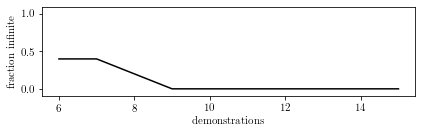

In [34]:
plt.close()
latexify(fig_width=6, fig_height=2)
plt.plot(rng, np.isnan(costs_lr).mean(axis=1), c='k')
plt.ylim(-.1,1.1)
plt.xlabel("demonstrations")
plt.ylabel("fraction infinite")
plt.tight_layout()
plt.savefig("figures/inf_small_random.pdf")